In [41]:
import pandas as pd
import plotnine
from plotnine import *
import seaborn as sns
import numpy as np
import matplotlib as plt


# Plot covariates

In [ ]:
with open("Bauges_data_covariates.csv", newline='') as my_csv:
            data_names = pd.read_csv(my_csv, sep=',', index_col=0)

In [ ]:
list(data_names.columns)

['bio_1_0', 'bio_12_0', 'bio_19_0', 'bio_8_0', 'slope', 'PC1', 'PC2']

In [ ]:
# the best clustering is: applam_d_4_fixed_out/rho_50_ranges_50_out_0
best_clust = pd.read_csv("best_clus.txt", sep=" ", header=None).astype(int)
#best_clust = best_clust.astype("category")

Numerosity of the clusters

In [ ]:
un , count = np.unique(np.array(best_clust[0]), return_counts=True)
count

array([212, 236, 221, 246, 224])

In [ ]:
df_cluster = data_names 
df_cluster.insert(0, "Cluster", best_clust)

In [ ]:
df_cluster["Cluster_fact"] = df_cluster["Cluster"].astype("category")

Box-plots for each of the covariate, with clusters

In [ ]:
bp_1 = ggplot(df_cluster, aes("Cluster_fact", "bio_1_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_1_0 distribution among clusters")

bp_2 = ggplot(df_cluster, aes("Cluster_fact", "bio_12_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_12_0 distribution among clusters")

bp_3 = ggplot(df_cluster, aes("Cluster_fact", "bio_19_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_19_0 distribution among clusters")

bp_4 = ggplot(df_cluster, aes("Cluster_fact", "bio_8_0", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("bio_8_0 distribution among clusters")



In [ ]:
print(bp_1)
print(bp_2)
print(bp_3)
print(bp_4)

In [ ]:
bp_slope = ggplot(df_cluster, aes("Cluster_fact", "slope", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("slope distribution among clusters")

bp_pc1 = ggplot(df_cluster, aes("Cluster_fact", "PC1", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("PC1 distribution among clusters")

bp_pc2 = ggplot(df_cluster, aes("Cluster_fact", "PC2", fill = "Cluster_fact")) \
+ geom_boxplot(show_legend=False) + xlab("cluster") + ggtitle("PC2 distribution among clusters")

print(bp_slope)
print(bp_pc1)
print(bp_pc2)

Pair plots 


In [ ]:
sns.pairplot(df_cluster, vars = ['bio_1_0', 'bio_12_0', 'bio_19_0','bio_8_0'], 
             hue = 'Cluster_fact')

# Species distribution within clusters

In [30]:
with open("Bauges_data.csv", newline='') as my_csv:
            data_species = pd.read_csv(my_csv, sep=',', index_col=0)

In [3]:
# the best clustering is: applam_d_4_fixed_out/rho_50_ranges_50_out_0
best_clust = pd.read_csv("best_clus.txt", sep=" ", header=None).astype(int)
#best_clust = best_clust.astype("category")

In [208]:
# Define the different indexes V for measuring association

### Compute Cramer's V [But to be substituted with meaningful index]
def cramers(cont):
    #Chi-squared test statistic, sample size, and minimum of rows and columns
    X2 = stats.chi2_contingency(cont, correction=False)[0]
    n = np.sum(cont)
    minDim = min(cont.shape)-1
    #calculate Cramer's V 
    return np.sqrt((X2/n) / minDim)

### Compute the ratio between sites with the species over the sites of the cluster
def jaccard(cont):
  return cont[1,1]/(cont[1,1]+cont[0,1]+cont[1,0])

In [209]:
from scipy.stats.contingency import crosstab
import scipy.stats as stats

num_largest = 3

nobs = best_clust.shape[0]
nspecies = data_species.shape[1]
nclusters = np.unique(np.array(best_clust[0])).size

# Relevent species (per cluster) in decreasing order and the V index for all the species (not ordered)
rel_species_pc = np.empty(nclusters, dtype=object)
V_species_pc = np.empty(nclusters, dtype=object)

for c in range(nclusters):
  ### Create the dummy: 1 if in cluster c, 0 if not in cluster c
  dum = 1*(best_clust == c).to_numpy().reshape(nobs)

  ### Extract each species columns, from the first to the last, and compute index
  V = np.empty(nspecies)
  for s in range(nspecies):
    sp = data_species[data_species.columns[s]].to_numpy()
    res = crosstab(dum,sp)
    cont_t = res[1]
    V[s] = jaccard(cont_t)

  ### Once computed the index for all the species, take the 3 largest ones
  ord_species = np.argsort(V)[::-1]
  rel_species_pc[c] = ord_species[0:num_largest]
  V_species_pc[c] = V



In [214]:
### Most relevant species within each group
print(rel_species_pc)

[array([113,  45,   0]) array([ 61, 113,  45]) array([ 22, 113,  14])
 array([45, 61, 80]) array([ 45, 113,  28])]


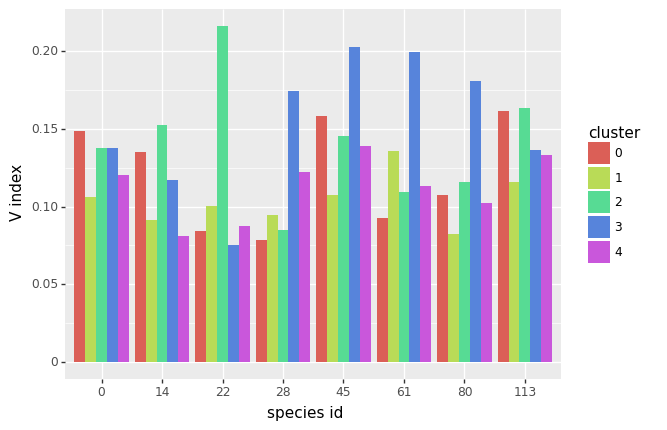

In [210]:
### Plot the results
rel_species = np.unique(np.concatenate(rel_species_pc))
V_rel_species_pc = np.array([V_sp[rel_species] for V_sp in V_species_pc]) 

# Build the dataframe with three columns (cluster, rel_species, V_rel_species)
num_rel_species = rel_species.size

col_cluster = np.repeat(range(nclusters), num_rel_species)
col_rel_species = np.tile(rel_species, nclusters)
col_V_rel_species = V_rel_species_pc.flatten()

df = pd.DataFrame({ 'cluster': col_cluster , 'rel_species' : col_rel_species, 'V_index': col_V_rel_species})
df['cluster']=df['cluster'].astype("category")
df['rel_species']=df['rel_species'].astype("category")

# Barplot with multiple groups
species = ggplot(df, aes("rel_species", "V_index", fill="cluster")) +  geom_bar(stat="identity", position="dodge") \
  + xlab("species id") + ylab("V index")
print(species)

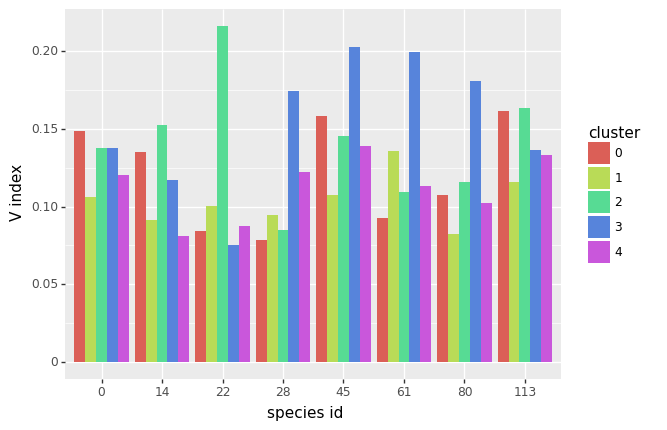

In [213]:
# Alternatively, each species bar is build in descreasing order [ACTUALLY THE SAME]
df_ord = df
g = df_ord.groupby('rel_species', as_index=False)
df_ord = g.apply(lambda x: x.sort_values('V_index', ascending=False))
df_ord = df_ord.reset_index(drop=True)
# Stacked barplot with multiple groups
species_ord = ggplot(df_ord, aes("rel_species", "V_index", fill="cluster")) +  geom_bar(stat="identity", position="dodge") \
  + xlab("species id") + ylab("V index")
print(species_ord)